In [1]:
import numpy as np
import pandas as pd
import glob
from fbprophet import Prophet
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

from math import ceil

import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1)

In [2]:
item_cat = pd.read_csv('../sales/item_categories.csv', encoding='utf-8')
items = pd.read_csv('../sales/items.csv')
train = pd.read_csv('../sales/sales_train_v2.csv')
shops = pd.read_csv('../sales/shops.csv')
test = pd.read_csv('../sales/test.csv', index_col = 'ID')

In [3]:
item_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [4]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [5]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [21]:
train.shop_id.unique

<bound method Series.unique of 0          59
1          25
2          25
3          25
4          25
           ..
2935844    25
2935845    25
2935846    25
2935847    25
2935848    25
Name: shop_id, Length: 2935849, dtype: int64>

In [18]:
train[train['item_id'] == 2552]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0
375824,25.04.2013,3,6,2552,949.0,1.0
419930,25.04.2013,3,30,2552,949.0,1.0
523067,24.05.2013,4,4,2552,949.0,1.0
531235,14.05.2013,4,6,2552,949.0,-1.0
679741,14.07.2013,6,22,2552,949.0,1.0
1723811,28.06.2014,17,28,2552,949.0,1.0
2648872,27.05.2015,28,50,2552,949.0,1.0


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
test['date_block_num'] = 34

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34


In [14]:
test

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34


In [9]:
group = pd.DataFrame(train.groupby( ['date_block_num', 'item_id'])['item_cnt_day'].sum())

In [10]:
group

item_cnt_day
date_block_num item_id              
0              19                1.0
               27                7.0
               28                8.0
               29                4.0
               32              299.0
...                              ...
33             22162            10.0
               22163            26.0
               22164            15.0
               22166            11.0
               22167            37.0

[233912 rows x 1 columns]

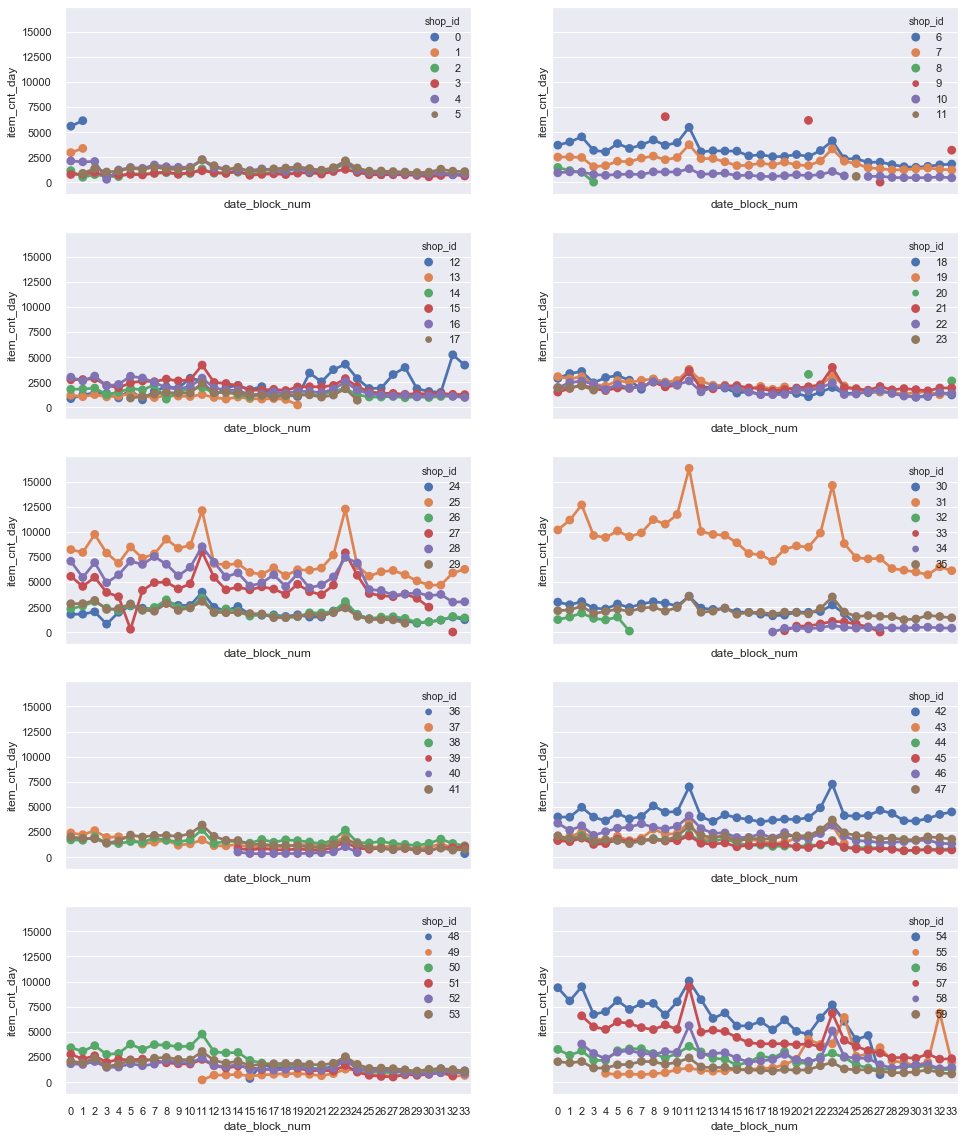

In [11]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)],
                      ax=axes[i][j])
        count += 1